In [59]:
import json
import pandas as pd
import numpy as np
import os
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd


sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CustomerChurn_EDA") \
    .master("local[*]") \
    .getOrCreate()

25/10/12 14:44:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
data = spark.read.parquet("../data/cleaned_churn_data.parquet")

In [10]:
data.printSchema()
data.show(5)
data.count()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- churn_flag: integer (nullable = true)

+-------+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+----------+
| userId|              arti

26259199

### I. Basic sanity checks

In [12]:
from pyspark.sql import functions as F

# Calculate the number of unique users
num_users = data.select("userId").distinct().count()
print(f"Number of unique users: {num_users}")

# Calculate the number of unique sessions
num_sessions = data.select("sessionId").distinct().count()
print(f"Number of unique sessions: {num_sessions}")

# Calculate the total number of events (rows)
num_events = data.count()
print(f"Total number of events (rows): {num_events}")

# Show all as a tuple for reference as well
counts_tuple = (num_users, num_sessions, num_events)
print(f"(num_users, num_sessions, num_events): {counts_tuple}")

Number of unique users: 22278
Number of unique sessions: 228713
Total number of events (rows): 26259199
(num_users, num_sessions, num_events): (22278, 228713, 26259199)


~26 million individual user actions recorded.

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_73969/1931752186.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=event_counts, x="count", y="page", palette="coolwarm")


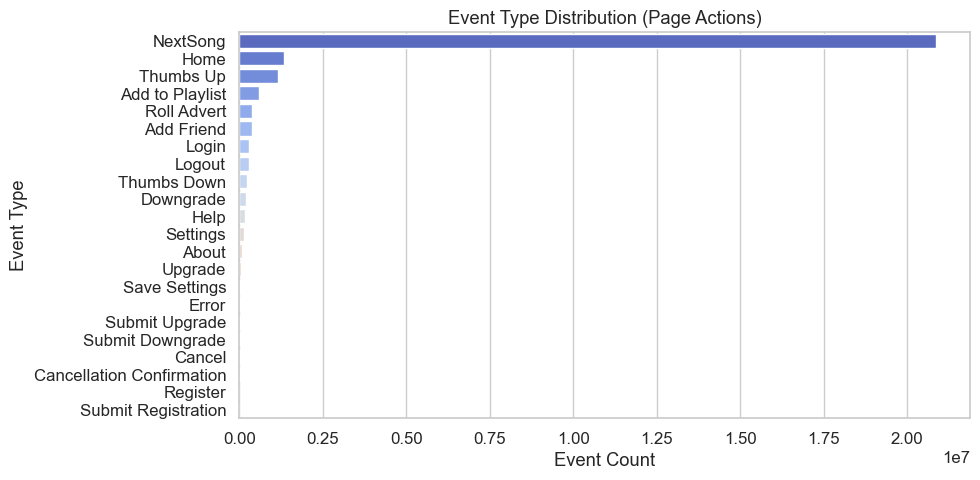

In [20]:
event_counts = (
    data.groupBy("page")
        .count()
        .orderBy(F.desc("count"))
        .toPandas()
)

plt.figure(figsize=(10,5))
sns.barplot(data=event_counts, x="count", y="page", palette="coolwarm")
plt.title("Event Type Distribution (Page Actions)")
plt.xlabel("Event Count")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()

### II. Missing values overview

In [13]:
data.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in data.columns]).show(truncate=False)

+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+
|userId|artist |auth|firstName|gender|itemInSession|lastName|length |level|location|method|page|registration|sessionId|song   |status|ts |userAgent|churn_flag|
+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+
|0     |5408927|0   |778479   |778479|0            |778479  |5408927|0    |778479  |0     |0   |778479      |0        |5408927|0     |0  |778479   |0         |
+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+



### III.  Churn rate

In [14]:
data.select("userId", "churn_flag").distinct().groupBy("churn_flag").count().show()

+----------+-----+
|churn_flag|count|
+----------+-----+
|         1| 5003|
|         0|17275|
+----------+-----+



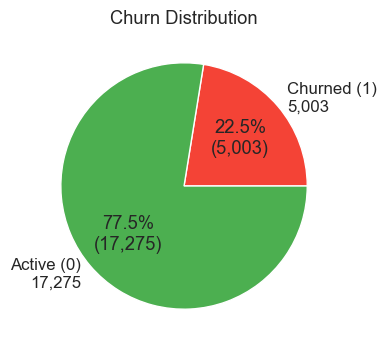

In [26]:
churn_counts = (
    data.select("userId", "churn_flag").distinct()
        .groupBy("churn_flag").count()
        .toPandas()
)

# Sort so labels and colors match: [Churned (1), Active (0)]
churn_counts_sorted = churn_counts.sort_values("churn_flag", ascending=False).reset_index(drop=True)
counts = churn_counts_sorted["count"].tolist()
labels = [f'Churned (1)\n{counts[0]:,}', f'Active (0)\n{counts[1]:,}']

plt.figure(figsize=(4,4))
plt.pie(
    churn_counts_sorted["count"], 
    labels=labels, 
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*sum(counts))):,})", 
    colors=["#F44336", "#4CAF50"]
)
plt.title("Churn Distribution")
plt.show()

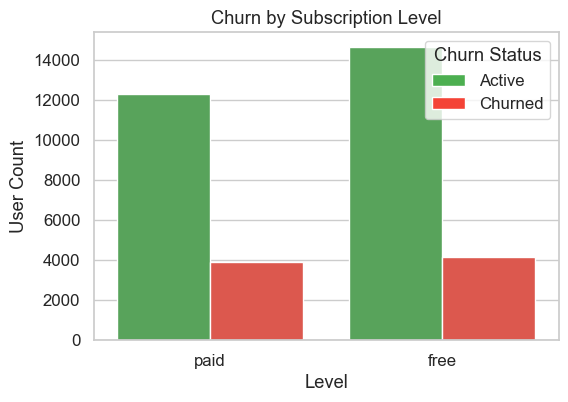

In [30]:
level_churn = (
    data.select("userId", "level", "churn_flag").distinct()
        .groupBy("level", "churn_flag").count()
        .toPandas()
)

plt.figure(figsize=(6,4))
sns.barplot(data=level_churn, x="level", y="count", hue="churn_flag", palette=["#4CAF50", "#F44336"])
plt.title("Churn by Subscription Level")
plt.xlabel("Level")
plt.ylabel("User Count")


legend_colors = ["#4CAF50", "#F44336"]
legend_labels = ["Active", "Churned"]
handles = [Patch(facecolor=c, label=l) for c, l in zip(legend_colors, legend_labels)]
plt.legend(handles=handles, title="Churn Status")
plt.show()

### IV. Gender & Level Distribution

In [15]:
data.select("userId", "gender", "level", "churn_flag").distinct().groupBy("gender", "churn_flag").count().show()
data.select("userId", "level", "churn_flag").distinct().groupBy("level", "churn_flag").count().show()

+------+----------+-----+
|gender|churn_flag|count|
+------+----------+-----+
|     M|         1| 4285|
|     F|         0|12887|
|     F|         1| 3753|
|     M|         0|14051|
|  NULL|         0|    2|
+------+----------+-----+



+-----+----------+-----+
|level|churn_flag|count|
+-----+----------+-----+
| paid|         0|12294|
| free|         0|14646|
| paid|         1| 3891|
| free|         1| 4147|
+-----+----------+-----+



/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_73969/2794262294.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


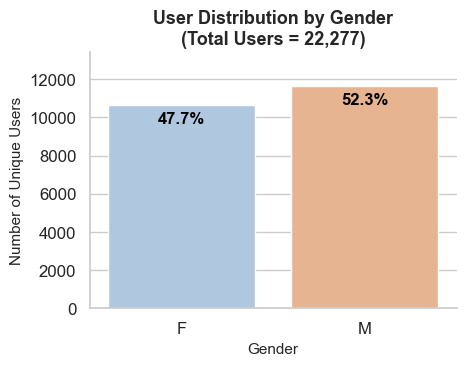

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# --- Aggregate unique users by gender, EXCLUDING NULLS ---
gender_user_counts = (
    data
    .filter(F.col("gender").isNotNull())
    .select("userId", "gender")
    .distinct()
    .groupBy("gender")
    .count()
    .withColumnRenamed("count", "num_users")
    .toPandas()
)

# --- Compute percentages ---
total_users = gender_user_counts["num_users"].sum()
gender_user_counts["percent"] = (
    100 * gender_user_counts["num_users"] / total_users
).round(1)

# --- Sort alphabetically (F, M) ---
gender_user_counts = gender_user_counts.sort_values("gender").reset_index(drop=True)

# --- Plot ---
plt.figure(figsize=(5.2, 4.2))
ax = sns.barplot(
    data=gender_user_counts,
    x="gender", y="num_users",
    palette=["#A7C7E7", "#F4B183"]
)

# --- Add percentage labels inside bars (well-framed) ---
for i, row in gender_user_counts.iterrows():
    ax.text(
        i, row["num_users"] * 0.97,
        f'{row["percent"]:.1f}%',
        ha='center', va='top',
        fontsize=12, color='black', fontweight='semibold'
    )

# --- Style adjustments for professional framing ---
ax.set_ylim(0, gender_user_counts["num_users"].max() * 1.15)
sns.despine(left=False, bottom=False)
plt.title(
    f"User Distribution by Gender\n(Total Users = {total_users:,})",
    fontsize=13, weight='semibold'
)
plt.xlabel("Gender", fontsize=11)
plt.ylabel("Number of Unique Users", fontsize=11)
plt.tight_layout(pad=2)
plt.show()

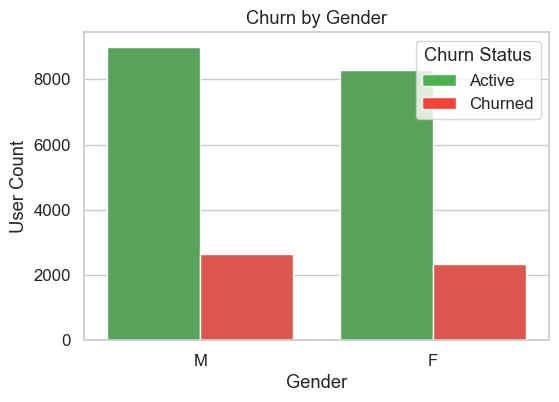

In [31]:
gender_churn = (
    data.select("userId", "gender", "churn_flag").distinct()
        .groupBy("gender", "churn_flag").count()
        .toPandas()
)

plt.figure(figsize=(6,4))
bar = sns.barplot(
    data=gender_churn, 
    x="gender", 
    y="count", 
    hue="churn_flag", 
    palette={0: "#4CAF50", 1: "#F44336"}
)
plt.title("Churn by Gender")
plt.xlabel("Gender")
plt.ylabel("User Count")
# Make custom legend matching color to 'Active' and 'Churned'
from matplotlib.patches import Patch
legend_colors = ["#4CAF50", "#F44336"]
legend_labels = ["Active", "Churned"]
handles = [Patch(facecolor=c, label=l) for c, l in zip(legend_colors, legend_labels)]
plt.legend(handles=handles, title="Churn Status")
plt.show()

### V. User activity intensity

In [16]:
activity = (
    data.groupBy("userId", "churn_flag")
        .agg(
            F.countDistinct("sessionId").alias("num_sessions"),
            F.count(F.when(F.col("page") == "NextSong", True)).alias("songs_played")
        )
)
activity.groupBy("churn_flag").agg(
    F.avg("num_sessions").alias("avg_sessions"),
    F.avg("songs_played").alias("avg_songs")
).show()

+----------+------------------+-----------------+
|churn_flag|      avg_sessions|        avg_songs|
+----------+------------------+-----------------+
|         1|12.300219868079152|876.7291625024985|
|         0|22.786685962373372|953.0533140376266|
+----------+------------------+-----------------+



### VI. Feature correlations (behavior vs churn)

In [17]:
from pyspark.sql.functions import avg

# Thumbs Up / Thumbs Down / Add to Playlist patterns
interactions = (
    data.groupBy("userId", "churn_flag")
        .agg(
            F.count(F.when(F.col("page") == "Thumbs Up", True)).alias("thumbs_up"),
            F.count(F.when(F.col("page") == "Thumbs Down", True)).alias("thumbs_down"),
            F.count(F.when(F.col("page") == "Add to Playlist", True)).alias("add_playlist")
        )
)
interactions.groupBy("churn_flag").agg(
    avg("thumbs_up").alias("avg_thumbs_up"),
    avg("thumbs_down").alias("avg_thumbs_down"),
    avg("add_playlist").alias("avg_add_playlist")
).show()

+----------+------------------+------------------+------------------+
|churn_flag|     avg_thumbs_up|   avg_thumbs_down|  avg_add_playlist|
+----------+------------------+------------------+------------------+
|         1|44.867479512292626|11.124525284829103| 24.91625024985009|
|         0| 53.66095513748191|10.625528219971056|27.395947901591896|
+----------+------------------+------------------+------------------+



### VII. Engagement duration

In [43]:
# Aggregate engagement features per user
engagement_df = (
    data.groupBy("userId", "churn_flag")
        .agg(
            F.countDistinct("sessionId").alias("num_sessions"),
            F.count(F.when(F.col("page") == "NextSong", True)).alias("num_songs"),
            F.count(F.when(F.col("page") == "Thumbs Up", True)).alias("thumbs_up"),
            F.count(F.when(F.col("page") == "Thumbs Down", True)).alias("thumbs_down"),
            F.count(F.when(F.col("page") == "Add to Playlist", True)).alias("add_playlist"),
            (F.max("ts") - F.min("ts")).alias("active_span_ms")
        )
        .withColumn("active_days", (F.col("active_span_ms") / (1000 * 60 * 60 * 24)))
)

# Convert to pandas for visualization
engagement_pdf = engagement_df.toPandas()
engagement_pdf.head()

,userId,churn_flag,num_sessions,num_songs,thumbs_up,thumbs_down,add_playlist,active_span_ms,active_days
0,1635735,0,21,1732,100,24,44,4752990000,55.011458
1,1322128,0,40,4450,206,47,135,5204927000,60.242211
2,1039401,0,8,856,42,8,23,3148590000,36.442014
3,1169629,0,24,1333,53,14,27,5111574000,59.161736
4,1789949,0,21,714,39,3,17,4787972000,55.416343


In [44]:
summary_stats = (
    engagement_pdf.groupby("churn_flag")
    [["num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"]]
    .mean()
    .round(2)
)
summary_stats

,num_sessions,num_songs,thumbs_up,thumbs_down,add_playlist,active_days
churn_flag,,,,,,
0,22.79,953.05,53.66,10.63,27.40,45.78
1,12.30,876.73,44.87,11.12,24.92,24.35


We can already see clear behavioral differences — churned users tend to have fewer sessions, fewer songs played, and shorter active periods.

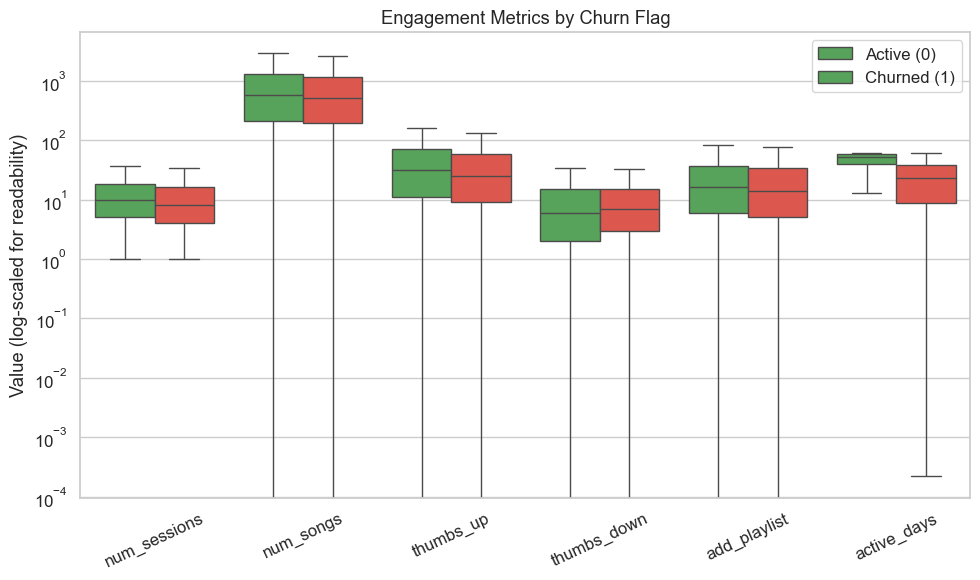

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10,6))

melted = engagement_pdf.melt(
    id_vars="churn_flag",
    value_vars=["num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"],
    var_name="metric", value_name="value"
)

sns.boxplot(data=melted, x="metric", y="value", hue="churn_flag",
            palette={0: "#4CAF50", 1: "#F44336"}, showfliers=False)

plt.title("Engagement Metrics by Churn Flag")
plt.xlabel("")
plt.ylabel("Value (log-scaled for readability)")
plt.yscale("log")
plt.legend(["Active (0)", "Churned (1)"])
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

### Insights:
- **Active users** show higher engagement across all dimensions: more sessions, more songs played, and longer activity spans.
- **Churned users** typically interact less and have fewer positive signals (likes, playlist additions).
- The number of **Thumbs Down** events is slightly higher relative to engagement among churners, suggesting dissatisfaction may contribute to churn.

In [49]:
# Correlation between engagement metrics and churn flag
corr = engagement_pdf.corr(numeric_only=True)["churn_flag"].sort_values(ascending=False)
corr

churn_flag        1.000000
thumbs_down       0.016506
num_sessions     -0.004131
num_songs        -0.028965
add_playlist     -0.032266
thumbs_up        -0.056815
active_days      -0.473456
active_span_ms   -0.473456
Name: churn_flag, dtype: float64

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_73969/3752608892.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.index, y=corr.values, palette="coolwarm")


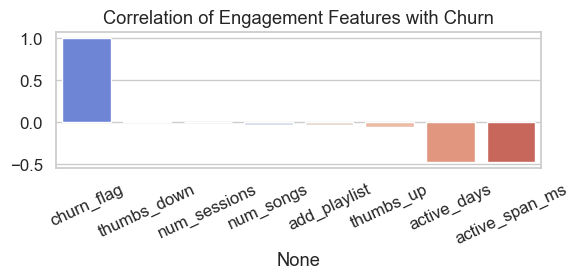

In [48]:
plt.figure(figsize=(6,3))
sns.barplot(x=corr.index, y=corr.values, palette="coolwarm")
plt.title("Correlation of Engagement Features with Churn")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

### IX. Event Type Exploration

## 6️⃣ Event Type Exploration

In this section, we explore user interactions — represented by the `page` variable.  
Each event corresponds to a specific user action such as playing a song, giving a thumbs up, or canceling their subscription.

We’ll first examine which event types dominate overall, and then compare their distribution between **active** and **churned** users.

#### 1. Count events by type

In [51]:
# Count frequency of each event type
event_counts = (
    data.groupBy("page")
        .count()
        .orderBy(F.desc("count"))
        .toPandas()
)

event_counts

,page,count
0,NextSong,20850272
1,Home,1343102
2,Thumbs Up,1151465
3,Add to Playlist,597921
4,Roll Advert,385212
5,Add Friend,381664
6,Login,296350
7,Logout,296005
8,Thumbs Down,239212
9,Downgrade,184240


/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_73969/1539695542.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=event_counts.head(15), y="page", x="count", palette="coolwarm")


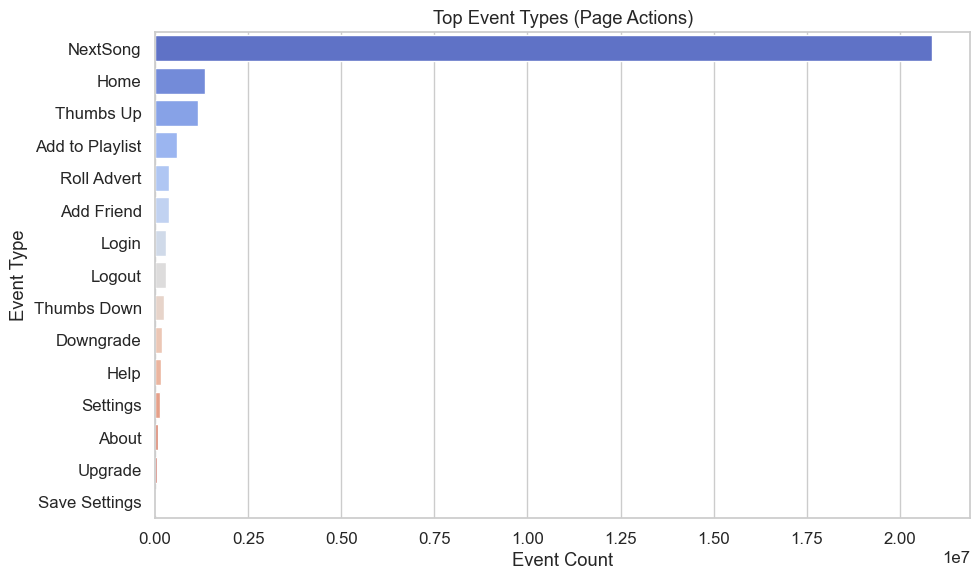

In [54]:
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10,6))
sns.barplot(data=event_counts.head(15), y="page", x="count", palette="coolwarm")

plt.title("Top Event Types (Page Actions)")
plt.xlabel("Event Count")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()

#### 2. Compare event patterns by churn status

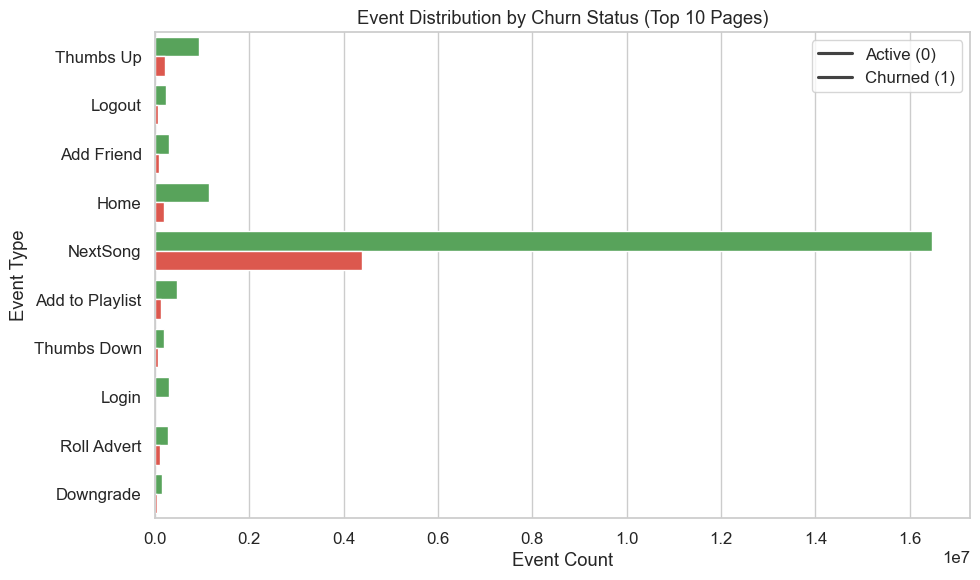

In [55]:
event_by_churn = (
    data.groupBy("page", "churn_flag")
        .count()
        .toPandas()
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=event_by_churn[event_by_churn["page"].isin(event_counts.head(10)["page"])],
    x="count", y="page", hue="churn_flag",
    palette={0: "#4CAF50", 1: "#F44336"}
)
plt.title("Event Distribution by Churn Status (Top 10 Pages)")
plt.xlabel("Event Count")
plt.ylabel("Event Type")
plt.legend(["Active (0)", "Churned (1)"])
plt.tight_layout()
plt.show()

#### 3. Normalize event proportions

In [60]:
# Normalize counts per churn_flag
event_share = (
    data.groupBy("churn_flag", "page")
        .count()
        .groupBy("page")
        .pivot("churn_flag")
        .sum("count")
        .fillna(0)
        .toPandas()
)

# Ensure columns are strings for compatibility
event_share.columns = event_share.columns.astype(str)

# If 0 or 1 are missing as columns after pivot, add them with zeros
for col in ["0", "1"]:
    if col not in event_share.columns:
        event_share[col] = 0

event_share["total"] = event_share["0"] + event_share["1"]
# Avoid division by zero
event_share["share_churned"] = event_share["1"] / event_share["total"].replace(0, np.nan) * 100
event_share = event_share.sort_values("share_churned", ascending=False).reset_index(drop=True)

event_share.head(10)

,page,0,1,total,share_churned
0,Cancel,0,5003,5003,100.000000
1,Cancellation Confirmation,0,5003,5003,100.000000
2,Roll Advert,284906,100306,385212,26.039168
3,Submit Upgrade,11448,3687,15135,24.360753
4,Downgrade,140816,43424,184240,23.569257
5,Thumbs Down,183556,55656,239212,23.266391
6,Submit Downgrade,4992,1502,6494,23.129042
7,Upgrade,39276,11231,50507,22.236522
8,Settings,115357,31717,147074,21.565334
9,Logout,233305,62700,296005,21.182075


/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_73969/682584469.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=event_share.head(10), x="share_churned", y="page", palette="Reds_r")


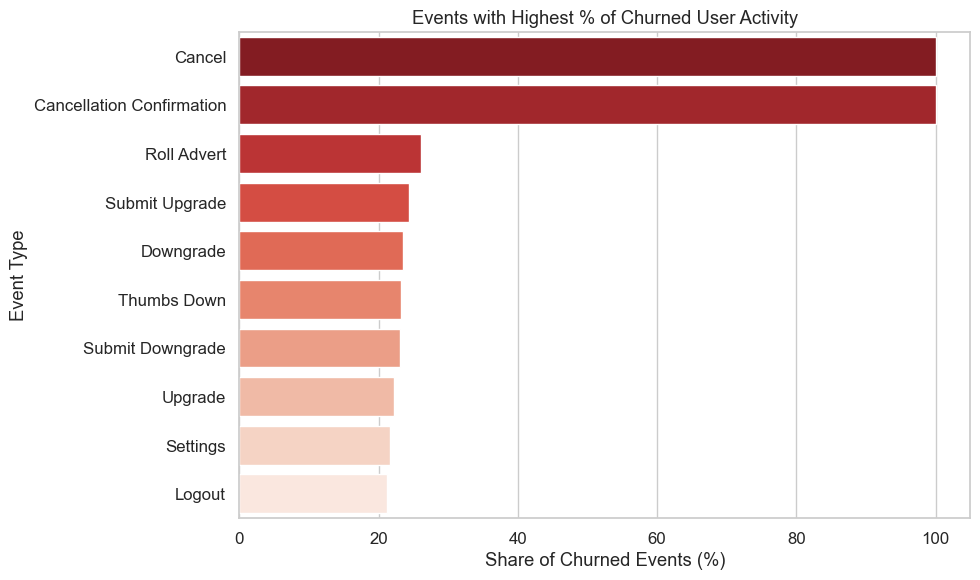

In [61]:
plt.figure(figsize=(10,6))
sns.barplot(data=event_share.head(10), x="share_churned", y="page", palette="Reds_r")
plt.title("Events with Highest % of Churned User Activity")
plt.xlabel("Share of Churned Events (%)")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()

### 🟥 Understanding the Difference: `Cancel` vs `Cancellation Confirmation`

In the dataset, the **`page`** column records every user action (event) on the platform.  
Two of these events — `Cancel` and `Cancellation Confirmation` — are closely related but have very different meanings:

| Page Event | Description | Indicates |
|-------------|-------------|------------|
| **Cancel** | The user *clicked on the "Cancel" button* to start the cancellation process. Some users may explore this option without actually completing it. | 🟡 *Intent to churn* (not a confirmed cancellation) |
| **Cancellation Confirmation** | The user *confirmed their cancellation* — meaning they officially unsubscribed and stopped using the service. | 🔴 *Actual churn* |

Therefore, in churn labeling we consider **only users who reached `Cancellation Confirmation` as churned**.  
This ensures that we capture **real customer attrition**, not just users exploring cancellation options.

> 💡 *Optional extension:* Users who clicked on `Cancel` but did not confirm can be analyzed as an *“at-risk”* group — those showing churn intent but still retained.

In [63]:
# How many users clicked "Cancel" but did NOT confirm ("at-risk" users)?

# Get all users who clicked "Cancel"
users_cancel = data.filter(data.page == "Cancel").select("userId").distinct()

# Get all users who had "Cancellation Confirmation"
users_canceled = data.filter(data.page == "Cancellation Confirmation").select("userId").distinct()

# "At-risk" users: those who clicked "Cancel" but not "Cancellation Confirmation"
users_at_risk = users_cancel.subtract(users_canceled)

num_at_risk = users_at_risk.count()
print(f"Number of users who clicked 'Cancel' but did not confirm (at-risk): {num_at_risk}")

Number of users who clicked 'Cancel' but did not confirm (at-risk): 0


### X. Correlations (Feature vs Churn)

To understand which user behaviors are most strongly associated with churn,  
we examine correlations between engagement features (sessions, songs, likes, etc.) and the churn flag.

This helps identify which features are likely to be **predictive** and will inform our modeling phase.

In [64]:
engagement_pdf = engagement_df.toPandas()

In [66]:
engagement_df = (
    data.groupBy("userId", "churn_flag")
        .agg(
            F.countDistinct("sessionId").alias("num_sessions"),
            F.count(F.when(F.col("page") == "NextSong", True)).alias("num_songs"),
            F.count(F.when(F.col("page") == "Thumbs Up", True)).alias("thumbs_up"),
            F.count(F.when(F.col("page") == "Thumbs Down", True)).alias("thumbs_down"),
            F.count(F.when(F.col("page") == "Add to Playlist", True)).alias("add_playlist"),
            (F.max("ts") - F.min("ts")).alias("active_span_ms")
        )
        .withColumn("active_days", (F.col("active_span_ms") / (1000 * 60 * 60 * 24)))
)
engagement_pdf = engagement_df.toPandas()

In [67]:
corr = engagement_pdf.corr(numeric_only=True).round(3)
corr["churn_flag"].sort_values(ascending=False)

churn_flag        1.000
thumbs_down       0.017
num_sessions     -0.004
num_songs        -0.029
add_playlist     -0.032
thumbs_up        -0.057
active_span_ms   -0.473
active_days      -0.473
Name: churn_flag, dtype: float64

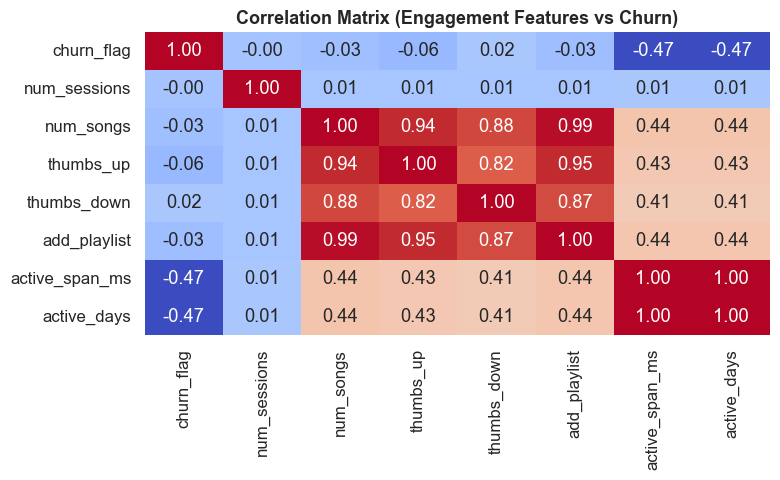

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=1.1)
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=False)
plt.title("Correlation Matrix (Engagement Features vs Churn)", fontsize=13, weight="semibold")
plt.tight_layout()
plt.show()

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_73969/3406003012.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_corr.values, y=churn_corr.index, palette="coolwarm")


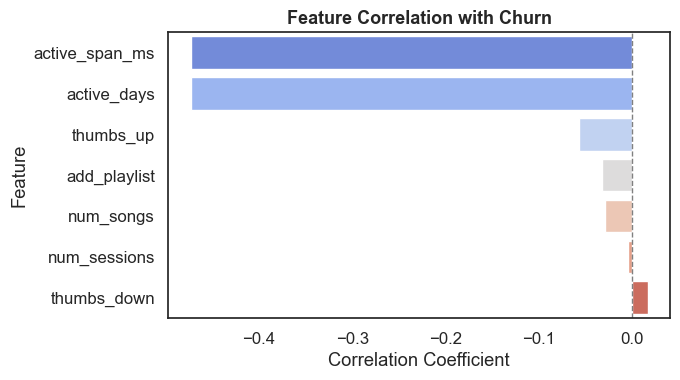

In [69]:
churn_corr = corr["churn_flag"].drop("churn_flag").sort_values()
plt.figure(figsize=(7,4))
sns.barplot(x=churn_corr.values, y=churn_corr.index, palette="coolwarm")
plt.title("Feature Correlation with Churn", fontsize=13, weight="semibold")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.axvline(0, color="gray", linestyle="--", lw=1)
plt.tight_layout()
plt.show()

### Insights:
- Features like **number of sessions**, **songs played**, and **active days** are **negatively correlated** with churn,  
  meaning that higher engagement corresponds to lower churn risk.
- **Thumbs Down** may show a slight **positive correlation** with churn, reflecting user dissatisfaction.
- These correlations confirm the intuition that **engagement intensity** is a key factor in retention.
- We'll use these variables as candidate predictors in our churn model.

### XI. Geographic Insights

In [73]:
data.columns

['userId',
 'artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'churn_flag']

The `location` field combines city and state information (e.g., *"San Francisco-Oakland-Hayward, CA"*).  
In this section, we analyze churn patterns by location to see whether certain regions have higher churn or engagement levels.

While geographic data is often only a proxy (e.g., time zones, demographics, or marketing coverage),  
it can still provide valuable insights for targeted retention strategies.

In [82]:
# Add 'state' and 'city' columns to main dataset 'data'
data = data.withColumn("state", F.split(F.col("location"), ", ").getItem(1))
data = data.withColumn("city", F.split(F.col("location"), ", ").getItem(0))

In [87]:
# Check top states
state_counts = (
    data.filter(F.col("state").isNotNull())
        .select("userId", "state")
        .distinct()
        .groupBy("state")
        .count()
        .orderBy(F.desc("count"))
        .toPandas()
)

state_counts.head(10)

,state,count
0,CA,2804
1,TX,1815
2,NY-NJ-PA,1570
3,FL,1423
4,OH,703
5,IL-IN-WI,682
6,MI,670
7,GA,622
8,PA,546
9,WA,504


/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_73969/3298518521.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_counts.head(10), y="state", x="count", palette="Blues_r")


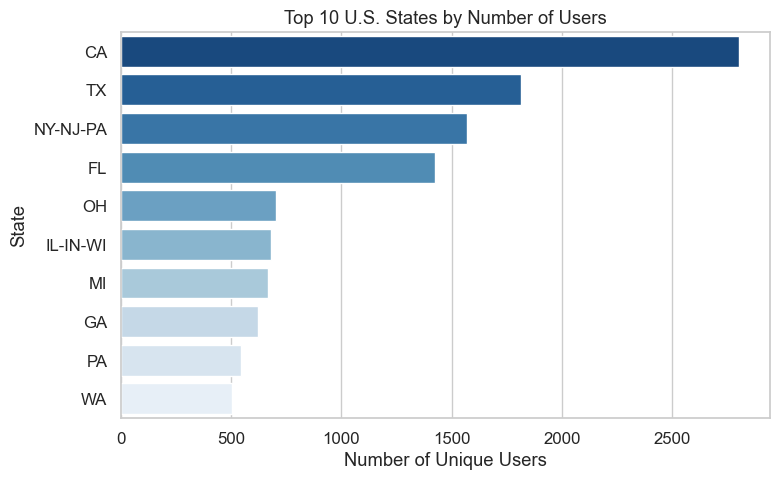

In [89]:
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(8,5))
sns.barplot(data=state_counts.head(10), y="state", x="count", palette="Blues_r")
plt.title("Top 10 U.S. States by Number of Users")
plt.xlabel("Number of Unique Users")
plt.ylabel("State")
plt.tight_layout()
plt.show()

In [90]:
churn_by_state = (
    data.filter(F.col("state").isNotNull())
        .select("userId", "state", "churn_flag")
        .distinct()
        .groupBy("state")
        .agg(
            F.count("*").alias("total_users"),
            F.sum("churn_flag").alias("churned_users")
        )
        .withColumn("churn_rate", (F.col("churned_users") / F.col("total_users")) * 100)
        .orderBy(F.desc("churn_rate"))
        .toPandas()
)

churn_by_state.head(10)

,state,total_users,churned_users,churn_rate
0,WV-VA,5,3,60.000000
1,OR-ID,4,2,50.000000
2,IL-MO,4,2,50.000000
3,WY-ID,4,2,50.000000
4,TX-AR,12,5,41.666667
5,WI-MI,5,2,40.000000
6,IA-IL-MO,5,2,40.000000
7,VA-WV,8,3,37.500000
8,WV-KY-OH,27,10,37.037037
9,MA-CT,61,22,36.065574


/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_73969/1513007063.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


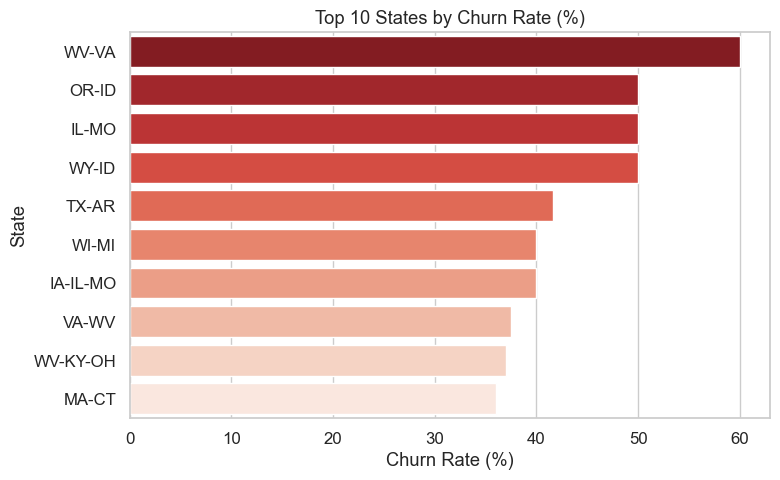

In [91]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=churn_by_state.head(10),
    x="churn_rate", y="state",
    palette="Reds_r"
)
plt.title("Top 10 States by Churn Rate (%)")
plt.xlabel("Churn Rate (%)")
plt.ylabel("State")
plt.tight_layout()
plt.show()

In [79]:
data.columns

['userId',
 'artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'churn_flag']

### Insights:
- The majority of users come from large metro states like **CA**, **TX**, **NY**, and **FL**.
- Churn rates vary by region — smaller states often show higher churn percentages due to smaller, less stable user bases.
- These findings can guide **localized marketing campaigns** or **regional retention strategies**.

In [92]:
import plotly.express as px
fig = px.choropleth(
    churn_by_state,
    locations="state",
    locationmode="USA-states",
    color="churn_rate",
    color_continuous_scale="Reds",
    scope="usa",
    title="Churn Rate by U.S. State"
)
fig.show()